In [117]:
# INIT
!git clone -q https: // github.com/AlpaslanErdag/cardata
import random
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
import glob
import pandas as pd
import cv2
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam, SGD  # - Works
from keras.models import Sequential
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import imutils



fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    --reject-shallow      don't clone shallow repository
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    --recursive ...       alias of --recurse-submodules
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --refere

In [63]:
# FUNCTIONS
def load_img_steering(datadir, df):
    image_path = []
    angle = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        image_id = indexed_data[0]
        image_path.append(os.path.join(datadir, image_id))
        angle.append(float(indexed_data[1]))
    image_paths = np.asarray(image_path)
    angles = np.asarray(angle)
    image_ids = np.asarray(image_id)
    return image_paths, angles


def load_speed_img(datadir, df):
    image_path1 = []
    speed1 = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        image_id = indexed_data[0]
        image_path1.append(os.path.join(datadir, image_id))
        speed1.append((indexed_data[2]))
    image_paths1 = np.asarray(image_path1)
    speeds1 = np.asarray(speed1)
    return image_paths1, speeds1


def load_test_img(datadir, df):
    test_path = []

    for i in range(len(data)):
        indexed_data = data.iloc[i]
        image_id = indexed_data[0]
        test_path.append(os.path.join(datadir, image_id))
        test_paths = np.asarray(test_path)

    return test_paths


def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image


def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


def img_random_brightness(image):
    brightness = iaa.Multiply((0.4, 1.2))
    image = brightness.augment_image(image)
    return image


def img_random_flip(image, angle):
    image = cv2.flip(image, 1)
    angle = 1 - angle
    return image, angle


def blur(image):
    kernel_size = random.randint(
        1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image, (kernel_size, kernel_size))

    return image


def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle


def angle_preprocess(img):
    #img = img[50:,:,:]
    img = img[int(img.shape[0] / 2):, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    #img = cv2.resize(img, (200, 66))
    img = (img * 255).astype(np.uint8)
    img = cv2.Canny(img, 100, 200)
    img = cv2.merge((img, img, img))
    img = cv2.resize(img, (200, 66))
    #img = img / 255.0
    #img = np.true_divide(image, 255, dtype=np.float32,casting="unsafe")
    return img


def speed_preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.resize(image, (200, 66))
    # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # lower = np.array([0, 164, 0])
    # upper = np.array([179, 255, 255])
    # mask = cv2.inRange(hsv, lower, upper)
    # image = cv2.bitwise_and(image, image, mask = mask)
    #image = image[int(image.shape[0] / 4):, :, :]
    return image


def angle_batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(
                0,
                len(image_paths) - 1
            )  # Picks random image in the dataset, creating a random batch of size batch_size

            if istraining:
                im, steering = random_augment(
                    image_paths[random_index], steering_ang[random_index]
                )  # If training data, augment the image

            else:
                im = mpimg.imread(
                    image_paths[random_index])  # If not, just load image
                steering = steering_ang[random_index]

            im = angle_preprocess(im)  # Pass image through pipeline
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering)
               )  # Returns generator/ lazy iterator


def speed_batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(
                0,
                len(image_paths) - 1
            )  # Picks random image in the dataset, creating a random batch of size batch_size

            if istraining:
                im = mpimg.imread(image_paths[random_index])  # Add image to dataset
                steering = steering_ang[random_index]

                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

                # Also augment the data and add to the dataset. Can loop here to increase dataset size
                # for i in range(3):
                #     im_aug, steering_aug = random_augment(image_paths[random_index], steering_ang[random_index])  
                #     im_aug = speed_preprocess(im_aug)
                #     batch_img.append(im_aug)
                #     batch_steering.append(steering_aug)

            else:
                im = mpimg.imread(image_paths[random_index])  # If not, just load image
                steering = steering_ang[random_index]

            im = speed_preprocess(im)  # Pass image through pipeline
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))  # Returns generator/ lazy iterator


def nvidia_model():

    model = Sequential()

    model.add(
        Conv2D(24,
               kernel_size=(5, 5),
               strides=(2, 2),
               input_shape=(66, 200, 3),
               activation='elu'))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-4)
    # model.compile(loss='mse', optimizer=optimizer)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model


In [95]:
datadir = "cardata"  # Define car data diretory
columns = ["image_id", "angle", "speed"]

# Read training data in from CSV
data = pd.read_csv(os.path.join(datadir, "training_norm3.csv"))

# Load angle/steering data
image_paths, angles = load_img_steering(
    datadir + "/training_data/training_data", data)

# Generate training/test split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,
                                                      angles,
                                                      test_size=0.2,
                                                      random_state=3)


In [ ]:
ncol = 4
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = angles[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  angle_image = angle_preprocess(augmented_image)
  speed_image = speed_preprocess(augmented_image)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

  axs[i][2].imshow(angle_image)
  axs[i][2].set_title("Angle Filter")

  axs[i][3].imshow(speed_image)
  axs[i][3].set_title("Speed Filter")
  print(speed_image.shape)

In [56]:
# TRAIN ANGLE MODEL
angle_model = nvidia_model()
batch_size = 64
steps_per_epoch = X_train.size/batch_size
angle_history = angle_model.fit(angle_batch_generator(X_train, y_train, batch_size,
                                                      1),
                                steps_per_epoch=300,
                                epochs=10,
                                validation_data=angle_batch_generator(
                                    X_valid, y_valid, batch_size, 0),
                                validation_steps=200,
                                verbose=1,
                                shuffle=1)



Epoch 1/10


2022-04-27 10:33:25.590230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 0.3072

2022-04-27 10:34:53.603062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 128s 427ms/step - loss: 0.3072 - val_loss: 0.0428
Epoch 2/10
300/300 [==============================] - 128s 426ms/step - loss: 0.0377 - val_loss: 0.0250
Epoch 3/10
300/300 [==============================] - 127s 424ms/step - loss: 0.0237 - val_loss: 0.0188
Epoch 4/10
300/300 [==============================] - 126s 422ms/step - loss: 0.0192 - val_loss: 0.0155
Epoch 5/10
300/300 [==============================] - 127s 423ms/step - loss: 0.0170 - val_loss: 0.0139
Epoch 6/10
300/300 [==============================] - 126s 420ms/step - loss: 0.0153 - val_loss: 0.0126
Epoch 7/10
300/300 [==============================] - 127s 423ms/step - loss: 0.0134 - val_loss: 0.0118
Epoch 8/10
300/300 [==============================] - 126s 421ms/step - loss: 0.0132 - val_loss: 0.0111
Epoch 9/10
300/300 [==============================] - 152s 509ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 10/10
300/300 [==============================] - 128s 427ms/step - lo

In [57]:
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model
# ANGLE PREDICTIONS BASED ON VALIDATION DATA

x_validTest, y_validTest = next(
    angle_batch_generator(X_valid, y_valid, 1000, 0))
Y_pred = angle_model.predict(x_validTest)
MSE_angle = mean_squared_error(y_validTest, Y_pred)
print(MSE_angle)

angle_model_name = "angle_model_" + "{0:.5f}".format(MSE_angle) + ".h5"
angle_models_path = os.path.join("models", angle_model_name)
angle_model.save(angle_models_path)

2022-04-27 10:55:02.476209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.011902423849727225


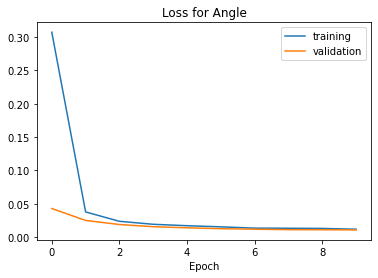

In [58]:
plt.plot(angle_history.history['loss'])
plt.plot(angle_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss for Angle')
plt.xlabel('Epoch')
plt.savefig(os.path.join("figures","angle_loss_" + "{0:.5f}".format(MSE_angle) + ".png"))

In [96]:
# Load angle/steering data
image_paths, speed = load_speed_img(datadir + "/training_data/training_data",
                                     data)

# Generate training/test split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,
                                                      speed,
                                                      test_size=0.2,
                                                      random_state=4)


['cardata/training_data/training_data/1.png'
 'cardata/training_data/training_data/2.png'
 'cardata/training_data/training_data/3.png' ...
 'cardata/training_data/training_data/13796.png'
 'cardata/training_data/training_data/13797.png'
 'cardata/training_data/training_data/13798.png']


In [136]:
# TRANSFER LEARNING ATTEMPT
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy

base_model = MobileNetV2(
    weights='imagenet', include_top=False
)  #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

model.compile(optimizer=SGD(learning_rate = 0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# datagen = ImageDataGenerator(featurewise_center=True,
#                              featurewise_std_normalization=True,
#                              rotation_range=20,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              horizontal_flip=True,
#                              validation_split=0.2)

# tg = datagen.flow(np.asarray(X_train), y_train, 32, 1, subset='training')
# vg = datagen.flow(np.asarray(X_valid), y_valid, 32, 1, subset='validation')

# test = ImageDataGenerator(preprocessing_function=preprocess_input)
# print(X_train)
# test_gen = test.flow_from_directory(X_train,
#                                     y_train,
#                                     batch_size=32,
#                                     color_mode='rgb')
# valid_gen = test.flow(np.asarray(X_valid), y_valid, 32, 0)

data = pd.read_csv("cardata/training_norm3.csv")
data['speed'] = data['speed'].astype(str)
print(data.head())

train_df, validate_df = train_test_split(data, test_size=0.20, random_state=42)
# train_df = train_df.reset_index(drop=True)
# validate_df = validate_df.reset_index(drop=True)
batch_size = 72

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "cardata/training_data/training_data/", 
    x_col='image_id',
    y_col='speed',
    target_size=(320,240),
    class_mode='binary',
    batch_size=batch_size,
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    "cardata/training_data/training_data/", 
    x_col='image_id',
    y_col='speed',
    target_size=(320,240),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)


speed_history = model.fit_generator(generator=train_generator,
                                    steps_per_epoch=train_generator.samples // batch_size,
                                    epochs=10,
                                    validation_data=valid_generator,
                                    validation_steps=valid_generator.samples // batch_size)

x_validTest, y_validTest = next(
    speed_batch_generator(X_valid, y_valid, 1000, 0))
Y_pred = model.predict(x_validTest)
bce = BinaryCrossentropy()
print(str(bce(y_validTest, Y_pred).numpy()))
speed_model_name = "speed_model_" + "{0:.5f}".str(bce(y_validTest, Y_pred).numpy()) + ".h5"
speed_models_path = os.path.join("models", speed_model_name)
model.save(speed_models_path)

plt.plot(speed_history.history['loss'])
plt.plot(speed_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss for Speed')
plt.xlabel('Epoch')
plt.savefig(os.path.join("figures","speed_loss_" + "{0:.5f}".str(bce(y_validTest, Y_pred).numpy()) + ".png"))


  image_id   angle speed
0    1.png  0.4375     0
1    2.png  0.8125     1
2    3.png  0.4375     1
3    4.png  0.6250     1
4    5.png  0.5000     0
Found 8828 validated image filenames belonging to 2 classes.
Found 551 validated image filenames belonging to 2 classes.


/Users/tomaldridge/miniforge3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10


2022-04-29 23:33:33.923032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9171

2022-04-29 23:35:10.641784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 103s 798ms/step - loss: 0.2093 - accuracy: 0.9171 - val_loss: 0.5998 - val_accuracy: 0.8254
Epoch 2/10
122/122 [==============================] - 93s 754ms/step - loss: 0.0914 - accuracy: 0.9643 - val_loss: 0.4712 - val_accuracy: 0.8571
Epoch 3/10
122/122 [==============================] - 94s 770ms/step - loss: 0.0737 - accuracy: 0.9717 - val_loss: 0.5139 - val_accuracy: 0.8591
Epoch 4/10
122/122 [==============================] - 90s 731ms/step - loss: 0.0571 - accuracy: 0.9786 - val_loss: 0.4764 - val_accuracy: 0.8849
Epoch 5/10
122/122 [==============================] - 91s 744ms/step - loss: 0.0525 - accuracy: 0.9808 - val_loss: 0.3728 - val_accuracy: 0.9008
Epoch 6/10
122/122 [==============================] - 90s 735ms/step - loss: 0.0481 - accuracy: 0.9816 - val_loss: 0.2107 - val_accuracy: 0.9345
Epoch 7/10
122/122 [==============================] - 94s 764ms/step - loss: 0.0443 - accuracy: 0.9838 - val_loss: 0.1514 - val_accuracy: 0.

In [135]:
from tensorflow.keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()
print(bce(y_validTest, Y_pred).numpy())
model.save("models/speed_model_" +str(bce(y_validTest, Y_pred).numpy())+".h5")

0.9253128


/Users/tomaldridge/miniforge3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [65]:

# TRAIN SPEED MODEL
speed_model = nvidia_model()
batch_size = 174
steps_per_epoch = X_train.size/batch_size


from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

speed_history = speed_model.fit(speed_batch_generator(X_train, y_train, batch_size,
                                                      1),
                                steps_per_epoch=300,
                                epochs=12,
                                validation_data=speed_batch_generator(
                                    X_valid, y_valid, batch_size, 0),
                                validation_steps=200,
                                callbacks=earlystopping,
                                verbose=1,
                                shuffle=1)

from sklearn.metrics import mean_squared_error, r2_score
# ANGLE PREDICTIONS BASED ON VALIDATION DATA

x_validTest, y_validTest = next(
    speed_batch_generator(X_valid, y_valid, 1000, 0))
Y_pred = speed_model.predict(x_validTest)
MSE_speed = mean_squared_error(y_validTest, Y_pred)
print(MSE_speed)

speed_model_name = "speed_model_" + "{0:.5f}".format(MSE_speed) + ".h5"
speed_models_path = os.path.join("models", speed_model_name)
speed_model.save(speed_models_path)

plt.plot(speed_history.history['loss'])
plt.plot(speed_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss for Speed')
plt.xlabel('Epoch')
plt.savefig(os.path.join("figures","speed_loss_" + "{0:.5f}".format(MSE_speed) + ".png"))


Epoch 1/12


2022-04-28 13:56:26.759950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 0.6838

2022-04-28 14:02:30.791231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 464s 2s/step - loss: 0.6838 - val_loss: 0.6634
Epoch 2/12
 46/300 [===>..........................] - ETA: 5:04 - loss: 0.6532

KeyboardInterrupt: 